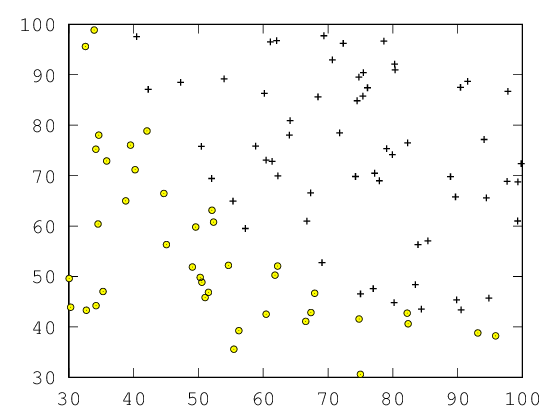

In [5]:
data = load('ex2data1.txt');
X = data(:, [1, 2]); y = data(:, 3);
pos = find(y == 1);
neg = find(y == 0);

plot(X(pos, 1), X(pos, 2), 'k+', 'LineWidth', 2, 'MarkerSize', 3);
hold on;
plot(X(neg, 1), X(neg, 2), 'ko', 'MarkerFaceColor', 'y', 'MarkerSize', 3);

### sigmoid function

$$
h_\theta(x)  =  g(\theta^Tx)  \\
g(z) = {1 \over 1 + e^{-z}}
$$

ans =  0.50000


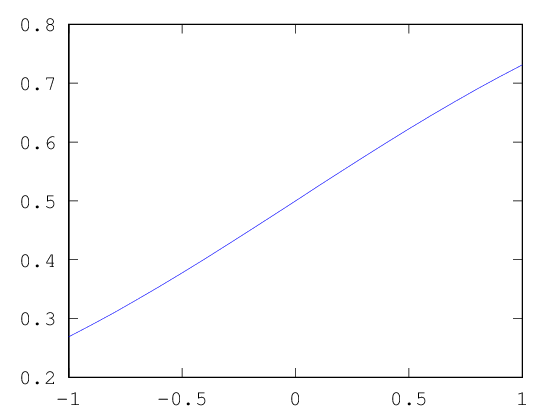

In [29]:
function g = sigmoid(z)
    es = ones(size(z)) * e;
    g = (es .^ (z * -1) + 1) .^ (-1);
endfunction

sigmoid(0)

x = -1:0.1:1;
y = sigmoid(x);
plot(x, y);

### Cost function

$$
\begin{eqnarray}
J(\theta) & = & {1 \over m}\sum_{i = 1}^m[
    -y^{(i)}log(h_\theta(x^{(i)}))
    - (1 - y^{(i)})log(1 - h_\theta(x^{(i)}))
] \\
{\partial J(\theta) \over \partial \theta_j}
& = & {1 \over m}\sum_{i = 1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
\end{eqnarray}
$$

In [ ]:
function [J, grad] = costFunction(theta, X, y)
    m = length(y);
    J = 0;
    grad = zeros(size(theta));
endfunction